- Code taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import pandas as pd

cudnn.benchmark = True
plt.ion() 

C:\Miniconda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
# Prepare dataset using external images
import os
import pathlib

dataset = []
root = "../../Dataset/extra images"
total_classes = os.listdir(root)
for _classidx, _class in enumerate(total_classes):
    filenames = os.listdir(f"{root}/{_class}")
    for idx, _file in enumerate(filenames):
        _,ext = os.path.splitext(_file)
        if (ext == ".jpg") or (ext == ".jpeg") or (ext ==".png"):
            oldfile = f"{root}/{_class}/{_file}"
            newfile = f"{root}/{_class}/img_{idx}{ext}"
            os.rename(oldfile, newfile)
            dataset.append((newfile, _class, _classidx))


In [55]:
data = pd.DataFrame(dataset, columns = ["ImagePath","LabelName","Labels"])
data = data.sample(frac=1).reset_index(drop = True)

total_labels = data[["LabelName","Labels"]].drop_duplicates()

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)
train.to_csv("../../Dataset/train.csv", index = False)
test.to_csv("../../Dataset/val.csv", index = False)


In [89]:
train.LabelName.value_counts()

vladimir putin      72
joe biden           56
bill clinton        56
donald trump        54
narendra modi       51
hillary clinton     50
robert downey jr    47
jill stein          44
ted cruz images     43
barack obama        41
gary johnson        40
john f. kennedy     38
ku klux klan        37
kim jong un         35
adolf hitler        32
bernie sanders      30
abraham lincoln     27
george bush         24
xi jinping          14
mike pence          14
kamala harris       14
mitch mcconnell     13
Name: LabelName, dtype: int64

In [56]:
class ImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_path,mode,root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.entityds = pd.read_csv(data_path)
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.entityds)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.entityds.loc[idx, "ImagePath"]
        image = cv2.imread(img_name)
        if self.transform:
            try:
                image = self.transform(image)
            except:
                print(img_name)
        
        labels = -1
        if self.mode != 'test':
            labels = self.entityds.loc[idx, "Labels"]
        #sample = {'image': image, 'entity': labels}

        return image, labels

In [59]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(.3),
        transforms.GaussianBlur(kernel_size=(5, 9)),
        transforms.ToTensor(),
        transforms.Normalize([0.3756, 0.3707, 0.4157],[1.8021, 1.7891, 1.9020])
        #transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3756, 0.3707, 0.4157],[1.8021, 1.7891, 1.9020])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
}

data_dir = '../Dataset/matchedpairs_finalds.csv'
image_datasets = {x: ImageDataset(data_path=f"../../Dataset/{x}.csv",
                                    mode=x,
                                    root_dir='../../Dataset/extra images/'
                                    ,transform= data_transforms[x])
                                    for x in ['train', 'val', 'test']}
                                    
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = total_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
# Get the mean band variance of entire dataset
print(image_datasets["train"][0][0].shape,dataset_sizes)
'''
total_samples = len(image_datasets["train"])
mean = 0
var = 0
for i in range(total_samples):
    image,_ = image_datasets["train"][i]
    mean += torch.mean(image, dim = [1,2])
mean = mean / total_samples
print(mean)

for i in range(total_samples):
    image = image_datasets["train"][i][0]
    image = image.view(image.size(0),-1)
    var += ((image - mean.unsqueeze(1))**2).sum([1])
var = torch.sqrt(var / (total_samples*224*224))
print(var)
'''


torch.Size([3, 2119, 2825]) {'train': 832, 'val': 209, 'test': 2}
tensor([0.3756, 0.3707, 0.4157])
tensor([1.8021, 1.7891, 1.9020])


In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': best_model_wts,
                            'class_names': class_names,
                            'loss': loss,
                            }, "../../Models/img_class_ed.pt")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [85]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3756, 0.3707, 0.4157])
    std = np.array([1.8021, 1.7891, 1.9020])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def visualize_model(model, mode='val', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[mode]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names.loc[class_names.Labels == preds[j].item(), "LabelName"].values[0]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [63]:
model_ft = models.resnet18(pretrained=True)
#for param in model_ft.parameters():
#    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(total_labels))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [68]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.0107 Acc: 0.5300
val Loss: 2.1380 Acc: 0.4211

Epoch 1/9
----------
train Loss: 1.6037 Acc: 0.6394
val Loss: 1.8267 Acc: 0.5024

Epoch 2/9
----------
train Loss: 1.2703 Acc: 0.7476
val Loss: 1.5882 Acc: 0.5885

Epoch 3/9
----------
train Loss: 1.0222 Acc: 0.8209
val Loss: 1.3861 Acc: 0.6746

Epoch 4/9
----------
train Loss: 0.8128 Acc: 0.8678
val Loss: 1.2823 Acc: 0.6603

Epoch 5/9
----------
train Loss: 0.6837 Acc: 0.9171
val Loss: 1.2581 Acc: 0.6986

Epoch 6/9
----------
train Loss: 0.6684 Acc: 0.9123
val Loss: 1.2361 Acc: 0.6938

Epoch 7/9
----------
train Loss: 0.6459 Acc: 0.9207
val Loss: 1.2327 Acc: 0.7081

Epoch 8/9
----------
train Loss: 0.6301 Acc: 0.9219
val Loss: 1.2180 Acc: 0.7177

Epoch 9/9
----------
train Loss: 0.6214 Acc: 0.9279
val Loss: 1.2044 Acc: 0.7033

Training complete in 9m 3s
Best val Acc: 0.717703


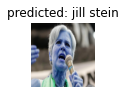

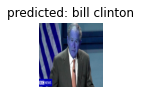

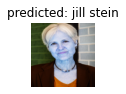

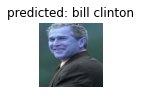

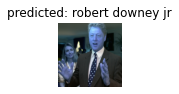

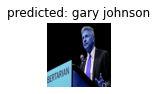

In [86]:
visualize_model(model_ft)

In [105]:
model_ft.eval()
result = []
for inputs, labels in dataloaders["val"]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    result+= list(zip(labels.cpu().numpy(),preds.cpu().numpy()))

In [109]:
from sklearn.metrics import classification_report
x = pd.DataFrame(result, columns = ["Actual","Pred"])
print(classification_report(x.Actual.values, x.Pred.values))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.75      1.00      0.86         3
           2       0.73      0.79      0.76        14
           3       0.80      0.67      0.73         6
           4       0.31      0.36      0.33        11
           5       0.55      0.65      0.59        17
           6       0.80      0.67      0.73        12
           7       0.50      0.09      0.15        11
           8       0.82      1.00      0.90        14
           9       1.00      0.79      0.88        14
          10       0.62      0.89      0.73         9
          11       0.60      0.75      0.67         8
          12       1.00      0.75      0.86         4
          13       0.82      0.75      0.78        12
          14       0.80      1.00      0.89         8
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       1.00    

C:\Miniconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Miniconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
class_names.sort_values("Labels")

,LabelName,Labels
55,abraham lincoln,0
14,adolf hitler,1
27,barack obama,2
12,bernie sanders,3
13,bill clinton,4
1,donald trump,5
5,gary johnson,6
15,george bush,7
4,hillary clinton,8
126,jill stein,9
